In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import requests
import json
from io import StringIO

# Tables

In [2]:
leuk_estimate = pd.read_csv("TCGA_all_leuk_estimate.masked.20170107.tsv", sep="\t", header=None, names=['code', 'barcode', 'leukocyte_fraction'])
cibersort_immune_fractions = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")

In [3]:
leuk_estimate.head()
#print(leuk_estimate.shape)

,code,barcode,leukocyte_fraction
0,ACC,TCGA-OR-A5J1-01A-11D-A29J-05,0.046374
1,ACC,TCGA-OR-A5J2-01A-11D-A29J-05,0.057859
2,ACC,TCGA-OR-A5J3-01A-11D-A29J-05,0.048460
3,ACC,TCGA-OR-A5J4-01A-11D-A29J-05,0.043988
4,ACC,TCGA-OR-A5J5-01A-11D-A29J-05,0.016759


In [4]:
cibersort_immune_fractions.head()
#print(cibersort_immune_fractions.shape)

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
0,TCGA.OR.A5JG.01A.11R.A29S.07,ACC,0.000000,0.048529,0.016052,0.046099,0.027037,0.290682,0.0,0.000000,...,0.363861,0.002715,0.026125,0.032788,0.000000,0.010290,0.009607,0.112,0.095797,1.047142
1,TCGA.OR.A5LG.01A.11R.A29S.07,ACC,0.007169,0.011125,0.007982,0.139842,0.000000,0.142742,0.0,0.001614,...,0.448243,0.000000,0.007464,0.126237,0.000000,0.000000,0.000000,0.104,0.103345,1.046163
2,TCGA.OR.A5JD.01A.11R.A29S.07,ACC,0.000023,0.014607,0.000000,0.104888,0.000000,0.174895,0.0,0.017928,...,0.329552,0.000000,0.009330,0.000000,0.190730,0.000000,0.000000,0.068,0.143259,1.039812
3,TCGA.OR.A5LH.01A.11R.A29S.07,ACC,0.047299,0.038180,0.000000,0.198591,0.000000,0.065240,0.0,0.043310,...,0.287939,0.000000,0.000576,0.000000,0.064725,0.000000,0.000000,0.388,0.028763,1.080553
4,TCGA.OR.A5KY.01A.11R.A29S.07,ACC,0.000000,0.024795,0.004418,0.051506,0.000000,0.225892,0.0,0.000000,...,0.486400,0.000000,0.042827,0.000000,0.017418,0.014769,0.000000,0.246,0.055621,1.073474


# Tasks:

## Step 1 Download the immune infiltration data estimated by CIBERsort using RNAseq data

1. Demonstrate that 'TCGA.Kallisto.fullIDs.cibersort.relative.tsv' is relative immune cell abundance (Hint, all the immune cell type fractions sum up to 1).

In [5]:
# Drop columns unrelated to each immune fraction, set each SampleID as the index for mapping results
total_immune_fractions = cibersort_immune_fractions.set_index("SampleID").drop(columns=["CancerType", "P.value", "Correlation", "RMSE"]).T.sum()

# Round total_immune_fraction to 5 decimal places, otherwise some logic tests will return False despite showing 1.0
print(total_immune_fractions.head())
print("Percentage of samples w/ total_immune_fraction == 1:", sum(total_immune_fractions.round(5) == 1)/len(total_immune_fractions)*100)

SampleID
TCGA.OR.A5JG.01A.11R.A29S.07    1.0
TCGA.OR.A5LG.01A.11R.A29S.07    1.0
TCGA.OR.A5JD.01A.11R.A29S.07    1.0
TCGA.OR.A5LH.01A.11R.A29S.07    1.0
TCGA.OR.A5KY.01A.11R.A29S.07    1.0
dtype: float64
Percentage of samples w/ total_immune_fraction == 1: 100.0


2. Calculate the absolute immune infiltration by using the 'Leukocyte Fraction' using 'TCGA_all_leuk_estimate.masked.20170107.tsv'.

    When joining two tables:
    - Make sure you explore the two data tables to understand the TCGA barcode and identify the unique keys to combine the two datasets.
    - There are some duplicated rows in the 'TCGA.Kallisto.fullIDs.cibersort.relative.tsv' file, make sure you spot them.
    - There are multiple aliquots from the same samples.

In [6]:
print('leuk_estimate shape:', leuk_estimate.shape)
print('cibersort shape:', cibersort_immune_fractions.shape)

leuk_estimate shape: (10817, 3)
cibersort shape: (11373, 27)


In [7]:
# Reading Barcodes:
#     TCGA-OR-A5JG-01A-11R-A29S-07
#     TCGA = Project
#         -OR = TSS (tissue source site)
#            -A5JG = Participant
#                 -01 = Sample
#                    A = Vial
#                     -11 = Portion
#                        R = Analyte
#                         -A29S = Plate
#                              -07 = Center

In [8]:
# Look for duplicated rows:
cibersort_immune_fractions.loc[cibersort_immune_fractions.duplicated()]

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
1591,TCGA.A2.A0EM.01A.11R.A034.07,BRCA,0.004896,0.001708,0.016635,0.057384,0.00000,0.145827,0.000000,0.030596,...,0.342965,0.047118,0.086246,0.163255,0.000000,0.000000,0.000000,0.052,0.128407,1.026685
1593,TCGA.A7.A0DC.11A.41R.A089.07,BRCA,0.026427,0.000000,0.043294,0.067376,0.00000,0.274335,0.000000,0.008326,...,0.358748,0.001146,0.004855,0.134192,0.000000,0.000000,0.000000,0.084,0.109721,1.036895
1596,TCGA.A7.A0DC.01A.11R.A00Z.07,BRCA,0.000000,0.131065,0.042677,0.000000,0.03579,0.066088,0.000000,0.000000,...,0.201406,0.000000,0.000000,0.118167,0.000000,0.000000,0.000000,0.234,0.047972,1.082571
1600,TCGA.BH.A0B2.01A.11R.A10J.07,BRCA,0.107727,0.000000,0.013158,0.087853,0.00000,0.210494,0.000000,0.039019,...,0.272480,0.000000,0.000000,0.043169,0.000000,0.000000,0.000000,0.014,0.186507,1.009395
6948,TCGA.37.4132.01A.01R.1100.07,LUSC,0.025366,0.011065,0.149130,0.190756,0.00000,0.094013,0.000000,0.092298,...,0.195212,0.000000,0.000000,0.000000,0.023930,0.003657,0.001991,0.010,0.263973,0.982453
11155,TCGA.FI.A2F8.01A.12R.A17B.07,UCEC,0.060899,0.000000,0.040943,0.136184,0.00000,0.214412,0.000000,0.125492,...,0.098374,0.000000,0.047474,0.000000,0.013248,0.000000,0.000000,0.046,0.149854,1.043185
11159,TCGA.AW.A1PO.01A.12R.A157.07,UCEC,0.000000,0.084401,0.000000,0.082413,0.00000,0.099352,0.000000,0.065142,...,0.255149,0.000000,0.221255,0.046272,0.000000,0.000000,0.000000,0.276,0.041101,1.071437
11160,TCGA.AJ.A23O.01A.11R.A157.07,UCEC,0.070062,0.000000,0.101062,0.297421,0.00000,0.069410,0.019222,0.242820,...,0.063330,0.002118,0.000000,0.006894,0.000000,0.000000,0.001456,0.030,0.211206,1.030980


In [9]:
cibersort_clean = cibersort_immune_fractions.loc[~cibersort_immune_fractions.duplicated()]
cibersort_clean.loc[:, "SampleID"] = cibersort_clean.SampleID.str.replace('.', '-')

# sanity check
cibersort_clean.value_counts("SampleID")

SampleID
TCGA-A7-A26I-01B-06R-A22O-07    3
TCGA-A7-A26F-01B-04R-A22O-07    3
TCGA-A7-A13G-01B-04R-A22O-07    3
TCGA-AC-A3OD-01B-06R-A22O-07    3
TCGA-A7-A0DC-01B-04R-A22O-07    3
                               ..
TCGA-B9-4116-01A-02R-1351-07    1
TCGA-B9-4117-01A-02R-1351-07    1
TCGA-B9-4617-01A-01R-1193-07    1
TCGA-B9-5155-01A-01R-1592-07    1
TCGA-ZX-AA5X-01A-11R-A42T-07    1
Name: count, Length: 11312, dtype: int64

In [10]:
# explore why these duplicates still exist...
cibersort_clean[cibersort_clean["SampleID"] == "TCGA-A7-A26I-01B-06R-A22O-07"]

,SampleID,CancerType,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,...,Macrophages.M2,Dendritic.cells.resting,Dendritic.cells.activated,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,P.value,Correlation,RMSE
1620,TCGA-A7-A26I-01B-06R-A22O-07,BRCA,0.085309,0.0,0.031425,0.023343,0.0,0.242160,0.0,0.023545,...,0.325628,0.0,0.037129,0.036999,0.004466,0.0,0.003262,0.022,0.168787,1.016652
1685,TCGA-A7-A26I-01B-06R-A22O-07,BRCA,0.098425,0.0,0.030734,0.039094,0.0,0.188020,0.0,0.006189,...,0.365039,0.0,0.016572,0.023577,0.000000,0.0,0.015725,0.012,0.213563,1.003626
1703,TCGA-A7-A26I-01B-06R-A22O-07,BRCA,0.052780,0.0,0.005174,0.035426,0.0,0.157295,0.0,0.058930,...,0.336936,0.0,0.014251,0.170058,0.000000,0.0,0.012387,0.042,0.141381,1.028662


In [11]:
# Nothing in the SampleID suggests these are different samples, since we only need 1 entry we'll take the mean of each

# check that each column is numeric
print(cibersort_clean.dtypes)

SampleID                         object
CancerType                       object
B.cells.naive                   float64
B.cells.memory                  float64
Plasma.cells                    float64
T.cells.CD8                     float64
T.cells.CD4.naive               float64
T.cells.CD4.memory.resting      float64
T.cells.CD4.memory.activated    float64
T.cells.follicular.helper       float64
T.cells.regulatory..Tregs.      float64
T.cells.gamma.delta             float64
NK.cells.resting                float64
NK.cells.activated              float64
Monocytes                       float64
Macrophages.M0                  float64
Macrophages.M1                  float64
Macrophages.M2                  float64
Dendritic.cells.resting         float64
Dendritic.cells.activated       float64
Mast.cells.resting              float64
Mast.cells.activated            float64
Eosinophils                     float64
Neutrophils                     float64
P.value                         float64


In [12]:
# Drop CancerType column and take the mean for the rest
cibersort_clean = cibersort_clean.drop(columns="CancerType").groupby(["SampleID"]).mean().reset_index()

# Confirm only one entry per SampleID
cibersort_clean.value_counts("SampleID")

SampleID
TCGA-02-0047-01A-01R-1849-01    1
TCGA-ER-A42H-01A-11R-A24X-07    1
TCGA-EO-A2CH-01A-11R-A180-07    1
TCGA-EO-A3AS-01A-11R-A19W-07    1
TCGA-EO-A3AU-01A-21R-A19W-07    1
                               ..
TCGA-B8-5163-01A-01R-1420-07    1
TCGA-B8-5164-01A-01R-1420-07    1
TCGA-B8-5165-01A-01R-1420-07    1
TCGA-B8-5545-01A-01R-1672-07    1
TCGA-ZX-AA5X-01A-11R-A42T-07    1
Name: count, Length: 11312, dtype: int64

In [13]:
# Quickly check if Vial, Portion, or Analyte corresponds with 'aliquot'
cibersort_participant = [x[2] for x in cibersort_clean.SampleID.str.split('-')]
cibersort_sample = [x[3][0:2] for x in cibersort_clean.SampleID.str.split('-')]
cibersort_vial = [x[3][2] for x in cibersort_clean.SampleID.str.split('-')]
cibersort_portion = [x[4][0:2] for x in cibersort_clean.SampleID.str.split('-')]
cibersort_analyte = [x[4][2] for x in cibersort_clean.SampleID.str.split('-')]
cibersort_plate = [x[5] for x in cibersort_clean.SampleID.str.split('-')]

cibersort_explore = pd.DataFrame(
    {
        'participant':cibersort_participant,
        'sample':cibersort_sample,
        'vial':cibersort_vial,
        'portion':cibersort_portion,
        'analyte':cibersort_analyte,
        'plate':cibersort_plate
    },
    index = cibersort_clean.SampleID
)

cibersort_explore.head()

,participant,sample,vial,portion,analyte,plate
SampleID,,,,,,
TCGA-02-0047-01A-01R-1849-01,0047,01,A,01,R,1849
TCGA-02-0055-01A-01R-1849-01,0055,01,A,01,R,1849
TCGA-02-2483-01A-01R-1849-01,2483,01,A,01,R,1849
TCGA-02-2485-01A-01R-1849-01,2485,01,A,01,R,1849
TCGA-02-2486-01A-01R-1849-01,2486,01,A,01,R,1849


In [14]:
# Find participants present twice
print(cibersort_explore.value_counts('participant'))

participant
5645    4
2662    4
A13E    4
2684    4
2668    4
       ..
8615    1
8616    1
8619    1
8620    1
AB4C    1
Name: count, Length: 10420, dtype: int64


In [15]:
# Look at A13G as an extreme example
cibersort_explore[cibersort_explore["participant"] == "5645"]

,participant,sample,vial,portion,analyte,plate
SampleID,,,,,,
TCGA-44-5645-01A-01R-1628-07,5645,01,A,01,R,1628
TCGA-44-5645-01A-01R-A278-07,5645,01,A,01,R,A278
TCGA-44-5645-01B-04R-A277-07,5645,01,B,04,R,A277
TCGA-44-5645-11A-01R-1628-07,5645,11,A,01,R,1628


In [16]:
# There does appear to be multiple samples and vials per participant, but nothing striking.
# See if the number of entries corresponds with the leukocyte_fraction

print('leuk_estimate shape:', leuk_estimate.shape)
print('cibersort shape:', cibersort_clean.shape)

leuk_estimate shape: (10817, 3)
cibersort shape: (11312, 26)


In [17]:
# Based on the TCGA website:
# "Analytes are extracted from each portion and distributed across one of more plates, where each well is identified as an aliquot"
# Let's update the Sample Key (i.e. SampleID) to exclude analyte, plate and center, and calculate the mean signal

cibersort_clean['SampleKey'] = [re.sub("R.*.", "", x) for x in cibersort_clean["SampleID"].to_list()]
cibersort_clean['SampleKey']

0        TCGA-02-0047-01A-01
1        TCGA-02-0055-01A-01
2        TCGA-02-2483-01A-01
3        TCGA-02-2485-01A-01
4        TCGA-02-2486-01A-01
                ...         
11307    TCGA-ZS-A9CG-01A-11
11308    TCGA-ZT-A8OM-01A-11
11309    TCGA-ZU-A8S4-01A-11
11310    TCGA-ZU-A8S4-11A-11
11311    TCGA-ZX-AA5X-01A-11
Name: SampleKey, Length: 11312, dtype: object

No match between SampleIDs, take a glance at each to see if any differences in formatting exist

In [18]:
cibersort_clean = cibersort_clean.drop(columns=["SampleID"]).groupby("SampleKey").mean().reset_index()

In [19]:
print(cibersort_clean.shape)

(10497, 26)


Slightly less entries than the leuk_estimate table now, let's see if the same needs to be repeated there...

In [20]:
leuk_estimate["SampleKey"] = [re.sub("([0-9][0-9])D.*.", r"\1", x) for x in leuk_estimate["barcode"]]
leuk_estimate.value_counts("SampleKey")

SampleKey
TCGA-44-4112-01A-01    2
TCGA-06-0125-01A-01    2
TCGA-A6-6781-01A-22    2
TCGA-A6-6780-01A-11    2
TCGA-A6-6650-01A-11    2
                      ..
TCGA-B0-5120-01A-01    1
TCGA-B0-5121-01A-02    1
TCGA-B0-5399-01A-01    1
TCGA-B0-5400-01A-01    1
TCGA-ZX-AA5X-01A-11    1
Name: count, Length: 10782, dtype: int64

There are some duplicates, let's check them out

In [21]:
leuk_estimate[leuk_estimate['SampleKey'] == "TCGA-44-4112-01A-01"]

,code,barcode,leukocyte_fraction,SampleKey
5543,LUAD,TCGA-44-4112-01A-01D-1104-05,0.213551,TCGA-44-4112-01A-01
5544,LUAD,TCGA-44-4112-01A-01D-A276-05,0.254616,TCGA-44-4112-01A-01


In [22]:
# different plates, let's take the mean again
leuk_clean = leuk_estimate.drop(columns=['code', 'barcode']).groupby("SampleKey").mean().reset_index()
leuk_clean

,SampleKey,leukocyte_fraction
0,TCGA-02-0001-01C-01,0.228080
1,TCGA-02-0002-01A-01,0.315280
2,TCGA-02-0003-01A-01,0.047688
3,TCGA-02-0006-01B-01,0.255156
4,TCGA-02-0007-01A-01,0.047660
...,...,...
10777,TCGA-ZS-A9CF-01A-11,0.059373
10778,TCGA-ZS-A9CF-02A-11,0.057896
10779,TCGA-ZS-A9CG-01A-11,0.133980
10780,TCGA-ZU-A8S4-01A-11,0.465039


In [23]:
# Get the common SampleKeys between each
common_keys = list(set(leuk_clean["SampleKey"]) & set(cibersort_clean["SampleKey"]))
print("Number of common SampleKey entries:", len(common_keys))

Number of common SampleKey entries: 9061


In [24]:
# Format each table and join
leuk_clean = leuk_clean.set_index("SampleKey")
cibersort_clean = cibersort_clean.set_index("SampleKey")

In [25]:
cibersort_absolute = cibersort_clean.drop(columns=["P.value", "Correlation", "RMSE"]).loc[common_keys].T * leuk_clean.loc[common_keys]["leukocyte_fraction"]

# Sanity check that the above operation is correct, the sum of all immune cells should add up to the leukocyte fraction:
cibersort_absolute.sum().round(2) == leuk_clean.loc[common_keys]["leukocyte_fraction"].round(2)

SampleKey
TCGA-XE-A8H4-01A-31    True
TCGA-FG-5963-01A-11    True
TCGA-EA-A5ZF-01A-11    True
TCGA-D7-6518-01A-11    True
TCGA-IZ-8195-01A-31    True
                       ... 
TCGA-CN-4741-01A-01    True
TCGA-HW-7491-01A-11    True
TCGA-WE-AAA3-06A-11    True
TCGA-UZ-A9PL-01A-11    True
TCGA-VQ-A91E-01A-31    True
Length: 9061, dtype: bool

In [26]:
cibersort_absolute.head(5)

SampleKey,TCGA-XE-A8H4-01A-31,TCGA-FG-5963-01A-11,TCGA-EA-A5ZF-01A-11,TCGA-D7-6518-01A-11,TCGA-IZ-8195-01A-31,TCGA-24-1842-01A-01,TCGA-24-1434-01A-01,TCGA-CN-4722-01A-01,TCGA-GU-AATQ-01A-11,TCGA-B0-5702-01A-11,...,TCGA-EE-A2GB-06A-11,TCGA-WB-A81M-01A-11,TCGA-UF-A7JD-01A-11,TCGA-A6-5659-01B-04,TCGA-G9-6363-01A-21,TCGA-CN-4741-01A-01,TCGA-HW-7491-01A-11,TCGA-WE-AAA3-06A-11,TCGA-UZ-A9PL-01A-11,TCGA-VQ-A91E-01A-31
B.cells.naive,0.062175,0.000209,0.008772,0.008838,0.000105,0.001825,0.000000,0.051853,0.000000,0.003945,...,0.007717,0.000811,0.001285,0.000000,0.018522,0.003605,0.000787,0.000000,0.000000,0.020195
B.cells.memory,0.000000,0.000000,0.000000,0.000000,0.000970,0.001086,0.009262,0.000000,0.010458,0.003293,...,0.000000,0.000000,0.000000,0.001493,0.000000,0.000000,0.000000,0.004882,0.001720,0.013108
Plasma.cells,0.000000,0.001188,0.011255,0.034257,0.000000,0.000900,0.000792,0.084432,0.003523,0.016783,...,0.007073,0.001070,0.017370,0.000000,0.000000,0.008058,0.000000,0.002380,0.000000,0.039561
T.cells.CD8,0.069735,0.017383,0.005217,0.012918,0.002096,0.022192,0.007962,0.050283,0.006428,0.070446,...,0.016507,0.002849,0.006708,0.000747,0.024801,0.014387,0.001028,0.077039,0.002897,0.045589
T.cells.CD4.naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.007918,0.000000,0.000000,0.000136,0.000000,0.000000,0.000000


3. Group similar immune cell types together and calculate the absolute immune infiltration for B_cells, T_cells, NK_cells, Monocytes, Macrophages, DCs, Mast, Eosinophils, and Neutrophils.

In [27]:
# Look at the each entry
cibersort_absolute['cell_type'] = [
    "B_cells" if "B.cells" in x else
    "T_cells" if "T.cells" in x else
    "NK_cells" if "NK.cells" in x else
    "Monocytes" if x == "Monocytes" else
    "Macrophages" if "Macrophages" in x else
    "DCs" if "Dendritic" in x else
    "Mast" if "Mast" in x else
    "Eosinophils" if x == "Eosinophils" else
    "Neutrophils" if "Neutrophils" in x else
    "Plasma_cells"
    for x in cibersort_absolute.index
]

cibersort_absolute[["cell_type"]]

SampleKey,cell_type
B.cells.naive,B_cells
B.cells.memory,B_cells
Plasma.cells,Plasma_cells
T.cells.CD8,T_cells
T.cells.CD4.naive,T_cells
T.cells.CD4.memory.resting,T_cells
T.cells.CD4.memory.activated,T_cells
T.cells.follicular.helper,T_cells
T.cells.regulatory..Tregs.,T_cells
T.cells.gamma.delta,T_cells


In [28]:
cibersort_abs_grouped = cibersort_absolute.groupby("cell_type").sum()
cibersort_abs_grouped

SampleKey,TCGA-XE-A8H4-01A-31,TCGA-FG-5963-01A-11,TCGA-EA-A5ZF-01A-11,TCGA-D7-6518-01A-11,TCGA-IZ-8195-01A-31,TCGA-24-1842-01A-01,TCGA-24-1434-01A-01,TCGA-CN-4722-01A-01,TCGA-GU-AATQ-01A-11,TCGA-B0-5702-01A-11,...,TCGA-EE-A2GB-06A-11,TCGA-WB-A81M-01A-11,TCGA-UF-A7JD-01A-11,TCGA-A6-5659-01B-04,TCGA-G9-6363-01A-21,TCGA-CN-4741-01A-01,TCGA-HW-7491-01A-11,TCGA-WE-AAA3-06A-11,TCGA-UZ-A9PL-01A-11,TCGA-VQ-A91E-01A-31
cell_type,,,,,,,,,,,,,,,,,,,,,
B_cells,0.062175,0.000209,0.008772,0.008838,0.001075,0.002910,0.009262,0.051853,0.010458,0.007238,...,0.007717,0.000811,0.001285,0.001493,0.018522,0.003605,0.000787,0.004882,0.001720,0.033303
DCs,0.000127,0.000000,0.003994,0.005357,0.000080,0.000000,0.000000,0.011484,0.002912,0.000000,...,0.000855,0.003517,0.001282,0.003249,0.010560,0.009921,0.000319,0.001633,0.000000,0.001447
Eosinophils,0.000000,0.000000,0.000187,0.004189,0.000000,0.000000,0.001886,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Macrophages,0.238949,0.169529,0.035406,0.082312,0.039963,0.061839,0.073048,0.073724,0.066391,0.080682,...,0.074308,0.008895,0.077454,0.009002,0.040580,0.036703,0.009162,0.136025,0.012490,0.040039
Mast,0.004013,0.000322,0.012863,0.014069,0.007985,0.003448,0.051996,0.009765,0.001575,0.005957,...,0.001371,0.002917,0.059989,0.005757,0.016916,0.001565,0.002619,0.008801,0.005694,0.006041
Monocytes,0.013165,0.018663,0.005948,0.006297,0.000000,0.006842,0.004812,0.014868,0.002963,0.030533,...,0.001186,0.003665,0.001409,0.001557,0.000000,0.004866,0.001751,0.014639,0.000480,0.003424
NK_cells,0.019073,0.002150,0.006176,0.007749,0.002783,0.014225,0.019559,0.006137,0.008207,0.032162,...,0.002806,0.003208,0.003615,0.004718,0.004332,0.003766,0.002940,0.013541,0.004298,0.013574
Neutrophils,0.000000,0.000658,0.000000,0.000392,0.000000,0.000000,0.004903,0.003071,0.000000,0.000000,...,0.000000,0.000000,0.001375,0.000000,0.000000,0.000414,0.003327,0.000000,0.000000,0.000147
Plasma_cells,0.000000,0.001188,0.011255,0.034257,0.000000,0.000900,0.000792,0.084432,0.003523,0.016783,...,0.007073,0.001070,0.017370,0.000000,0.000000,0.008058,0.000000,0.002380,0.000000,0.039561


4. Plot the immune infiltration of T cells across all cancer types in a boxplot and order the box by the median level of T cell infiltration from high to low.

In [29]:
# Get the cancer type for each ID
cibersort_cancer_type = cibersort_immune_fractions[["SampleID", "CancerType"]]
cibersort_cancer_type.loc[:, "SampleID"] = cibersort_cancer_type["SampleID"].str.replace(".", "-")
cibersort_cancer_type.loc[:, "SampleID"] = [re.sub("([0-9][0-9])R.*.", r"\1", x) for x in cibersort_cancer_type["SampleID"]]
cibersort_cancer_type = cibersort_cancer_type[~cibersort_cancer_type.duplicated()]

cibersort_cancer_type = cibersort_cancer_type.set_index("SampleID").loc[cibersort_absolute.drop(columns=["cell_type"]).columns]
cibersort_cancer_type["t_cell_infiltration"] = cibersort_abs_grouped.T.T_cells
cibersort_cancer_type

,CancerType,t_cell_infiltration
SampleKey,,
TCGA-XE-A8H4-01A-31,TGCT,0.199498
TCGA-FG-5963-01A-11,LGG,0.045866
TCGA-EA-A5ZF-01A-11,CESC,0.031298
TCGA-D7-6518-01A-11,STAD,0.120820
TCGA-IZ-8195-01A-31,KIRP,0.010787
...,...,...
TCGA-CN-4741-01A-01,HNSC,0.042620
TCGA-HW-7491-01A-11,LGG,0.003870
TCGA-WE-AAA3-06A-11,SKCM,0.110580


<Axes: xlabel='CancerType', ylabel='t_cell_infiltration'>

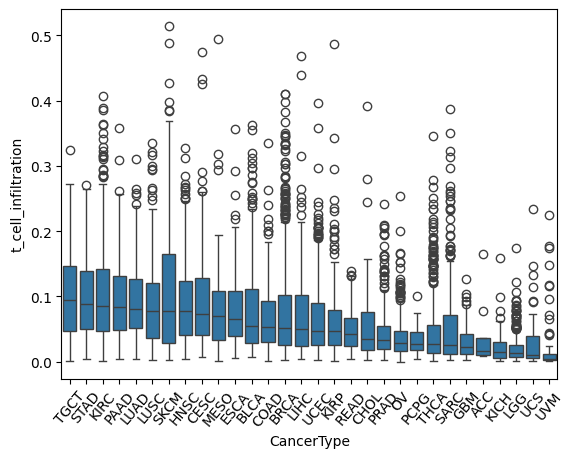

In [30]:
cancer_median_sort = cibersort_cancer_type.groupby("CancerType").median().sort_values("t_cell_infiltration", ascending=False).index
g = sns.boxplot(cibersort_cancer_type, x="CancerType", y="t_cell_infiltration", order=cancer_median_sort)
plt.xticks(rotation=50)
g

5. Get the median level of immune infiltration of B_cells, T_cells, NK_cells, Monocytes, Macrophages, DCs, Mast and Eosinophils per cancer type and plot them in a heatmap.

In [31]:
cibersort_by_cancer = cibersort_abs_grouped.T
cibersort_by_cancer["CancerType"] = cibersort_cancer_type["CancerType"]
cibersort_by_cancer = cibersort_by_cancer.groupby("CancerType").median()

cibersort_by_cancer

cell_type,B_cells,DCs,Eosinophils,Macrophages,Mast,Monocytes,NK_cells,Neutrophils,Plasma_cells,T_cells
CancerType,,,,,,,,,,
ACC,0.001643,0.000923,0.0,0.024846,0.002860,0.005670,0.003387,0.000000,0.000259,0.016995
BLCA,0.008597,0.006695,0.0,0.064195,0.008227,0.003231,0.008204,0.000000,0.005457,0.054672
BRCA,0.008506,0.001334,0.0,0.076393,0.010517,0.001640,0.003013,0.000000,0.003882,0.051849
CESC,0.006867,0.009042,0.0,0.059810,0.008122,0.002580,0.013177,0.000000,0.009135,0.072439
CHOL,0.007544,0.001695,0.0,0.059235,0.003668,0.002410,0.008094,0.000278,0.001788,0.034951
COAD,0.006611,0.001379,0.0,0.056109,0.009843,0.001351,0.005260,0.000000,0.003854,0.053698
ESCA,0.008508,0.006759,0.0,0.056787,0.011026,0.003764,0.008789,0.000000,0.005137,0.065379
GBM,0.001668,0.000000,0.0,0.083093,0.006752,0.008344,0.007314,0.002705,0.000000,0.022342
HNSC,0.005822,0.010430,0.0,0.114445,0.010253,0.001529,0.011204,0.000005,0.005214,0.077173


<Axes: xlabel='CancerType', ylabel='cell_type'>

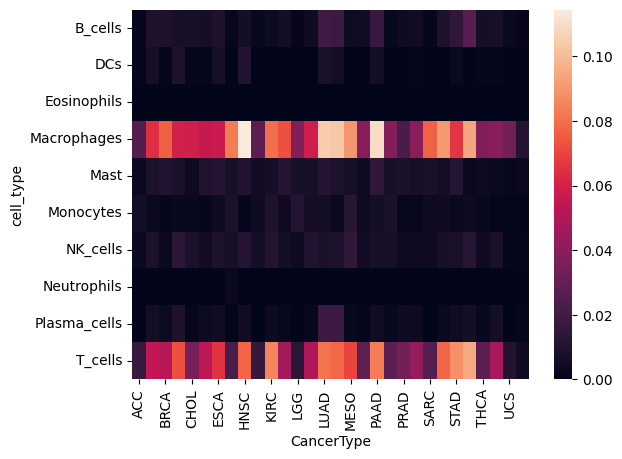

In [32]:
sns.heatmap(cibersort_by_cancer.T)

## Step 2 Get the mutation data

Download the mutation data for LUAD (lung adenocarcinoma) from TCGA. (you choose a resource that you want to get this information).

Now, use that mutation data to stratify the patients in the 'TCGA.Kallisto.fullIDs.cibersort.relative.tsv' based on the EGFR mutation status: EGFR wildtype, Exon 20 insertion mutation, Exon19 deletion mutation, pL858R mutation and other missense mutations.

Note the mutation file may not tell you the exon number for the mutations. You will need to cross check the mutation position(chr, start, end) with the gene model annotation (e.g., gtf file). The same tumor sample may also have multiple EGFR mutations.

In [34]:
# Get mutation data using the GDC API
cases_endpt = 'https://api.gdc.cancer.gov/files'

# The 'fields' parameter is passed as a comma-separated string of single names.
fields = [
    "data_format",
    "data_type",
    "data_category",
    "access",
    "cases.project.project_id",
    "cases.submitter_id",
    "file_id",
    ]

fields = ','.join(fields)

filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content": {
            "field": "cases.project.project_id",
            "value": ["TCGA-LUAD"]
            },
        },
        {
        "op": "in",
        "content":{
            "field": "access",
            "value": ["open"]
            },
        },
        {
        "op": "in",
        "content":{
            "field": "data_format",
            "value": ["MAF"]
            },
        },
        {
        "op": "in",
        "content": {
            "field": "data_type",
            "value": ["Masked Somatic Mutation"]
            },
        }
    ]
}

params = {
    "filters": json.dumps(filters),
    "fields": fields,
    "format": "TSV",
    "size":5000,
    }

response = requests.get(cases_endpt, params = params)

In [35]:
tsvStringIO = StringIO(response.text)
df = pd.read_csv(tsvStringIO, sep="\t")
df.head()

,access,cases.0.project.project_id,cases.0.submitter_id,data_category,data_format,data_type,file_id,id
0,open,TCGA-LUAD,TCGA-73-4658,Simple Nucleotide Variation,MAF,Masked Somatic Mutation,be733141-d5f0-4e24-b512-2eaa9786d6ee,be733141-d5f0-4e24-b512-2eaa9786d6ee
1,open,TCGA-LUAD,TCGA-38-4630,Simple Nucleotide Variation,MAF,Masked Somatic Mutation,a2e630bf-b7a4-4f1c-af45-21183089137f,a2e630bf-b7a4-4f1c-af45-21183089137f
2,open,TCGA-LUAD,TCGA-78-7166,Simple Nucleotide Variation,MAF,Masked Somatic Mutation,f3783fb1-d04b-4132-bafc-ba27741c82e4,f3783fb1-d04b-4132-bafc-ba27741c82e4
3,open,TCGA-LUAD,TCGA-55-1592,Simple Nucleotide Variation,MAF,Masked Somatic Mutation,8a0ad5f7-749a-487d-952a-603ec1a5de50,8a0ad5f7-749a-487d-952a-603ec1a5de50
4,open,TCGA-LUAD,TCGA-73-4670,Simple Nucleotide Variation,MAF,Masked Somatic Mutation,a86d8d33-7f58-483b-9e7a-d650c26322c4,a86d8d33-7f58-483b-9e7a-d650c26322c4


In [36]:
#### Make sure that the number of samples is below the API limit (i.e. 5000).
print(df.shape) # confirmed on GDC Data Portal

(618, 8)


In [39]:
# Download the files, only needs to be run once so change run = True if needed
run = False
if run:
    data_endpt = "https://api.gdc.cancer.gov/data"
    
    ids = df['file_id'].to_list()
    
    params = {"ids": ids}
    
    response = requests.post(data_endpt,
                             data = json.dumps(params),
                             headers={
                                 "Content-Type": "application/json"
                             })
    
    response_head_cd = response.headers["Content-Disposition"]
    
    file_name = re.findall("filename=(.+)", response_head_cd)[0]
    
    with open(file_name, "wb") as output_file:
        output_file.write(response.content)

In [38]:
# The resulting tar.gz file was unpacked into a folder called gdc_data, collate each file into a table..
